### **Load Data**

In [1]:
import pandas as pd

# Load data set

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    return df

file_path = '../data/flight_df.csv'
df = load_data(file_path)

df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split

# Define target variable
y =df['satisfied']
X = df.drop(columns='satisfied')

In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Check for class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [4]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Select numeric and categorical columns
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

# Instantiate transformer
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')
imputer = KNNImputer(n_neighbors=2, weights='uniform') # Use KNN algorithm to impute missing values to preserve data integrity

# preprocessing pipeline
def preprocessing_pipeline():
    
    num_pipe = Pipeline([
        ('scaler', scaler),
        ('imputer', imputer)
    ])
    
    cat_pipe = Pipeline([
        ('encoder', encoder)
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ])
    
    return preprocessor

# Create preprocessor object
preprocessor = preprocessing_pipeline()

In [5]:
from imblearn.over_sampling import SMOTE # Synthetic Minority Oversampling TEchnique
from imblearn. pipeline import Pipeline as ImbalancePipeline

# Create sampler pipeline
def sampler_pipeline(sampler):
    
    return ImbalancePipeline([
        ('sampler', sampler)
    ])
    
# Create sampler object
sampler = sampler_pipeline(SMOTE(random_state=42))

# preprocess and rebalance the dataset
def preprocess_and_rebalance(preprocessor, X_train, X_test, y_train):
    
    # transform training data to the fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Rebalance training load_data
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_transformed, y_train)
    
    return X_train_balanced, X_test_transformed, y_train_balanced

# Preprocess and Rebalance the dataset

X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance(preprocessor, X_train, X_test, y_train)

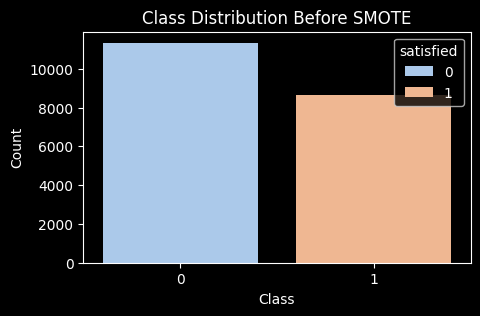

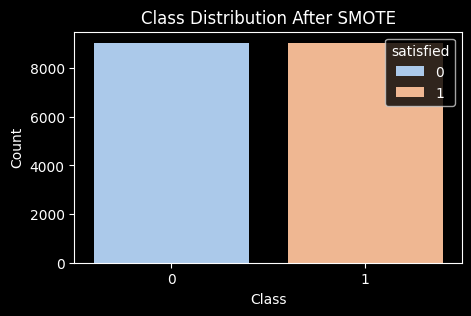

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dark mode
plt.style.use('dark_background')

# Visualize data before SMOTE
def plot_distribution(y, title):
    plt.figure(figsize=(5, 3))
    sns.countplot(
        x=y, # y is the target variable 'satisfied'
        palette = 'pastel',
        hue=y
    )
    
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    
# Visualize data before SMOTE
plot_distribution(y, title='Class Distribution Before SMOTE')

# Visualize data after SMOTE
plot_distribution(y_train_balanced, title='Class Distribution After SMOTE')

In [7]:
# Convert preprocessed data back to a dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

### **Machine Learning**

In [8]:
from lazypredict.Supervised import LazyClassifier
# Instantiate the model
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
# Make predictions
models, predictions = lazy_clf.fit(X_train_balanced_df, X_test_transformed_df, y_train_balanced, y_test)
# Return models
models

 13%|█▎        | 4/31 [00:04<00:25,  1.07it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 29%|██▉       | 9/31 [00:07<00:19,  1.11it/s]

FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 87%|████████▋ | 27/31 [02:57<00:13,  3.33s/it]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


 97%|█████████▋| 30/31 [02:58<00:01,  1.78s/it]

[LightGBM] [Info] Number of positive: 9051, number of negative: 9051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4676
[LightGBM] [Info] Number of data points in the train set: 18102, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [02:58<00:00,  5.76s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.95,0.95,0.96,0.47
XGBClassifier,0.96,0.95,0.95,0.96,0.34
RandomForestClassifier,0.95,0.95,0.95,0.95,3.49
ExtraTreesClassifier,0.95,0.95,0.95,0.95,2.68
BaggingClassifier,0.95,0.94,0.94,0.95,1.58
SVC,0.94,0.94,0.94,0.94,6.18
DecisionTreeClassifier,0.94,0.94,0.94,0.94,0.31
AdaBoostClassifier,0.93,0.93,0.93,0.93,2.32
KNeighborsClassifier,0.92,0.91,0.91,0.92,0.66


In [9]:
# Return top 5 models
top_5_models = models.sort_values('F1 Score', ascending=False).head()
top_5_models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.95,0.95,0.96,0.47
XGBClassifier,0.96,0.95,0.95,0.96,0.34
RandomForestClassifier,0.95,0.95,0.95,0.95,3.49
ExtraTreesClassifier,0.95,0.95,0.95,0.95,2.68
BaggingClassifier,0.95,0.94,0.94,0.95,1.58


### **EvaluatioN**

In [15]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):

    # Make predictions
    train_preds = np.rint(model.predict(X_train))
    test_preds = np.rint(model.predict(X_test))

    # Classification report
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)

    # Confusion matrix
    train_cm = confusion_matrix(y_train, train_preds)
    test_cm = confusion_matrix(y_test, test_preds)

    # Define labels
    labels = ['Not Satisfied', 'Satisfied']

    # Plot confusion matrices side-by-side Training
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(train_report), fontproperties='monospace')
    axes[0].axis('off')

    # Second axis
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=labels)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Training Confusion Matrix')

    # Plot confusion matrices side-by-side Testing
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(test_report), fontproperties='monospace')
    axes[0].axis('off')

    # Second axis
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)
    disp_test.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

    return train_report, test_report

In [16]:
# ML pipeline
def train_and_predict(X_train, y_train, X_test, preprocessor, model):
    
    # Complete pipeline and model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit model
    model_pipeline.fit(X_train, y_train)
    
    # Save predictions
    train_preds = model_pipeline.predict(X_train)
    test_preds = model_pipeline.predict(X_test)
    
    return train_preds, test_preds

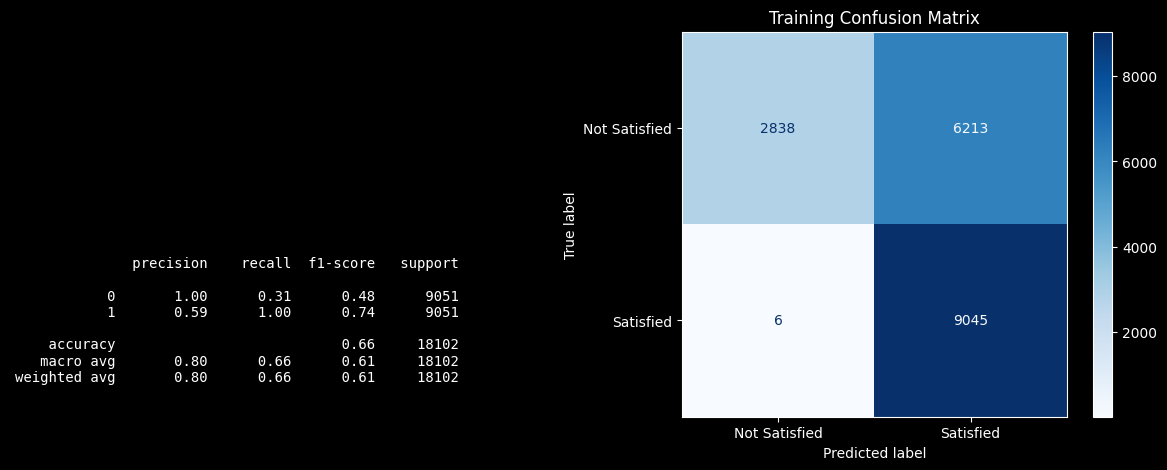

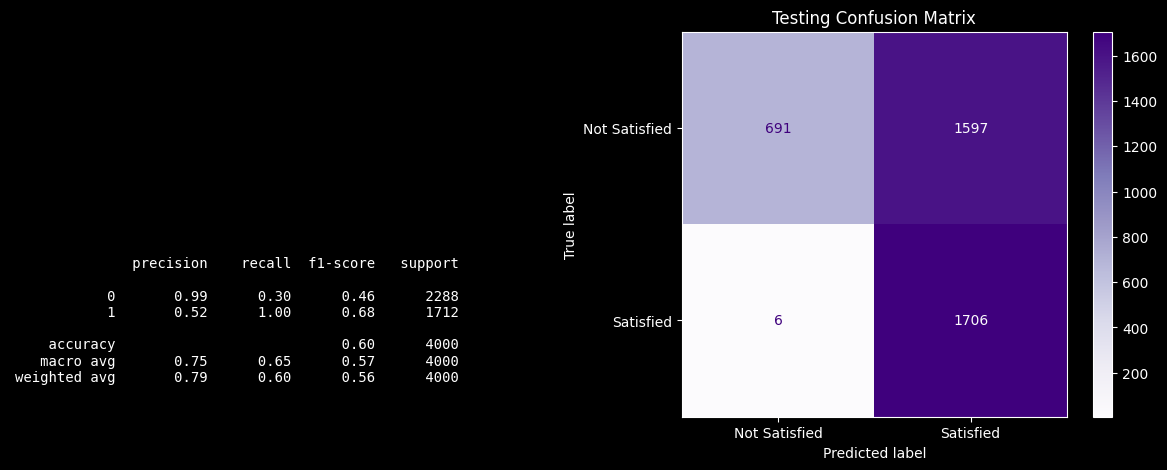

In [27]:
import lightgbm as lgb

# Instantiate the model
lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create and save predictions
train_preds, test_preds = train_and_predict(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgb_model)

# Return train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

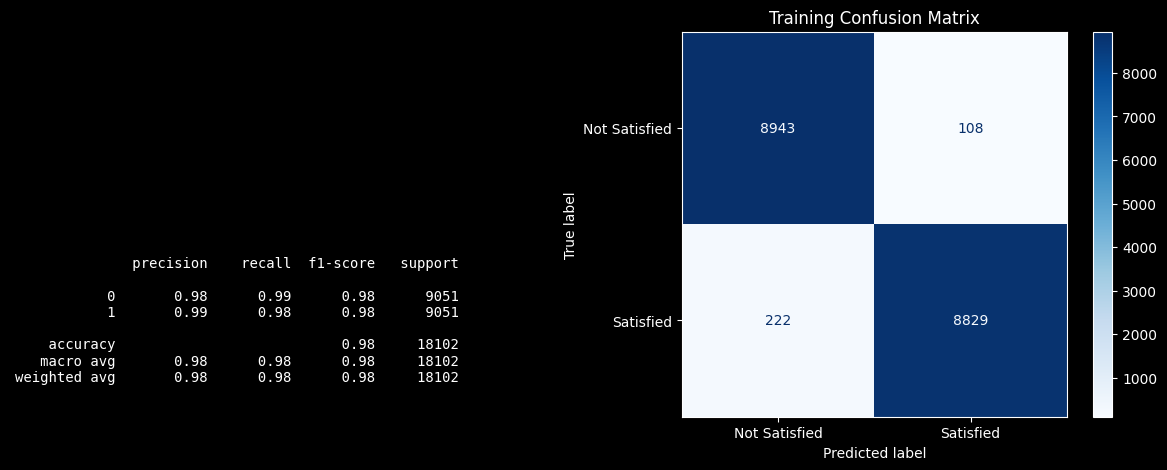

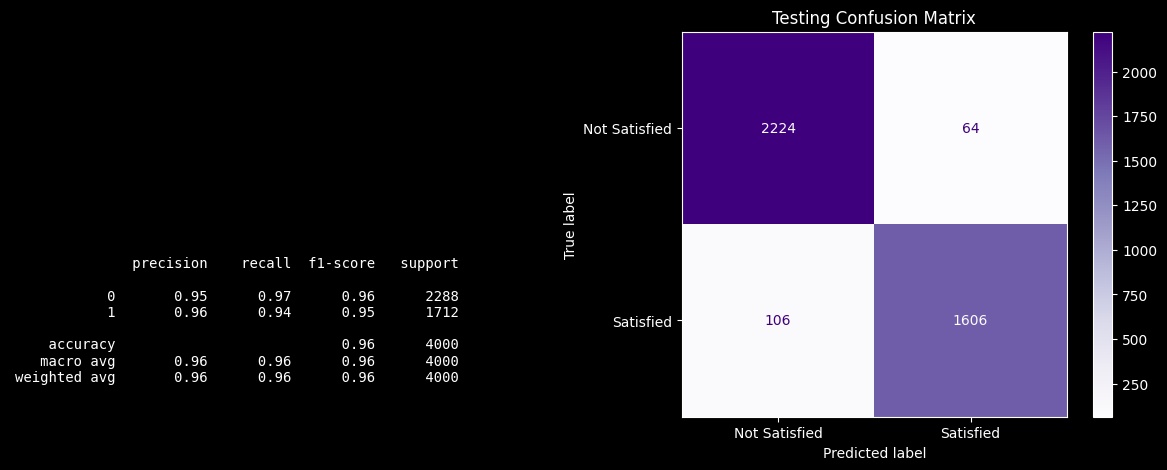

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
dec_tree = DecisionTreeClassifier()

# Create and save predictions
train_preds, test_preds = train_and_predict(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_tree)

# Return train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

In [ ]:
# import lightgbm as lgb
# from sklearn.tree import DecisionTreeClassifier

# # Run models as a loop
# models = [
#     ('LGBMClassifier', lgb.LGBMClassifier(verbose=-1, random_state=42)),
#     ('DecisionTreeClassiier', DecisionTreeClassifier())
# ]

# # Store prediction results
# results = {}

# # Train and predict model
# for model_name, model in models:
#     train_preds, test_preds = train_and_predict(
#         X_train_balanced_df,
#         y_train_balanced,
#         X_test_transformed_df,
#         preprocessor,
#         model
#         )
    
# # Return train and test reports
# train_report, test_report = evaluate_model(
#     model,
#     X_train_balanced_df,
#     y_train_balanced,
#     X_test_transformed_df,
#     y_test
# )

# # Store results


### **Feature Importance**

In [24]:
# Train Model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    
    return model

# Get feature imprtances
def get_feature_importance(model):
    feature_names = X_train.columns
    importances = model.feature_importances_
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return feature_importance

# Plot feature importances
def plot_feature_importance(feature_importance, title):
    plt.figure(figsize=(10,5))
    
    # Barplot
    sns.barplot(
        data=feature_importance,
        x='importance',
        y='feature',
        hue='feature'
    )
    
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

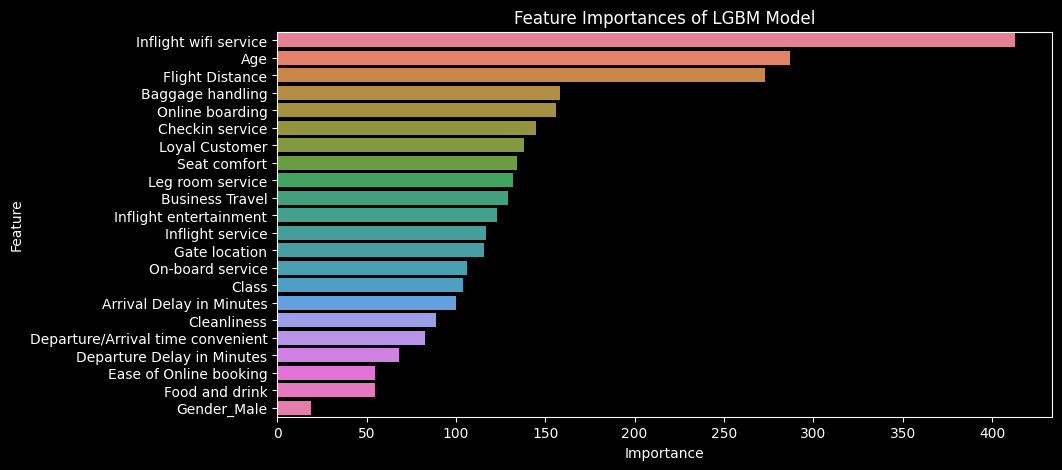

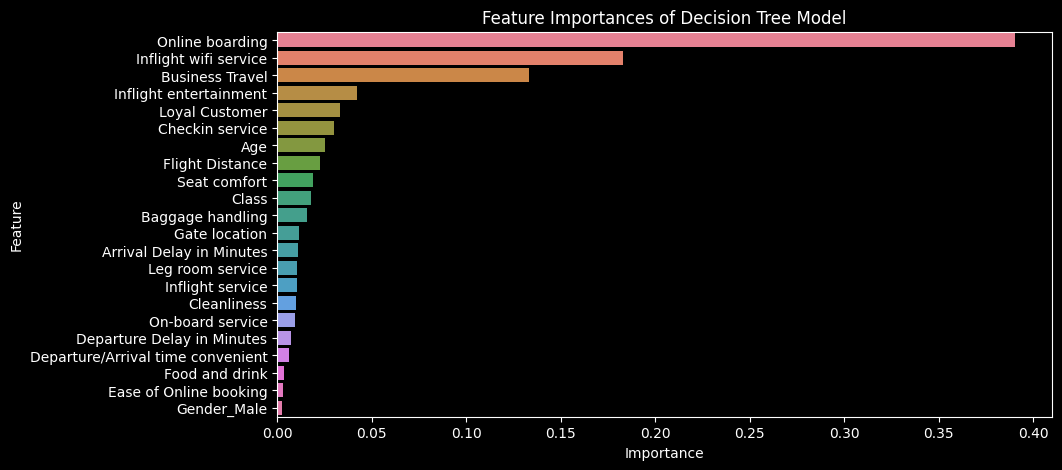

In [25]:
# train LGBM model
trained_lgb_model = train_model(lgb_model, X_train_balanced_df, y_train_balanced)

# Get and plot feature importances of LGBM Model
lgb_feature_importance = get_feature_importance(trained_lgb_model)
plot_feature_importance(lgb_feature_importance, title='Feature Importances of LGBM Model')

# train Decision tree
trained_dec_tree_model = train_model(dec_tree, X_train_balanced_df, y_train_balanced)

# Get and plot feature importances of Dec Treee
dec_tree_feature_importance = get_feature_importance(trained_dec_tree_model)
plot_feature_importance(dec_tree_feature_importance, title='Feature Importances of Decision Tree Model')